# Classifying Traffic Signs

The following code builds off the LeNet lab from the Udacity self driving car nano degree, term 1. I have written my own architiecture for a new convolutional neural net following inpiriation from the GoogLeNet paper and source [2]. defined below. 
I still have a network with a humble number of layers, though I've added something akin to an inception module as described in source [1], and a n extra fully connected layer in the final stages of the network. Additionaly, I added dropout to the weights of the fully connected layers, excluding the logit layer, and l2 regularization penalties on all fully connected layer weights. I tuned all the hyper parameters mannually to get a decent score. 
___

Additinally, I added the preprocessing steps of appending an upside-down rotation to of all labeled data, doubling the number of training examples and divided all values of input data by 255, forcing the range to [0, 1].
___

Before final testing, I tried the network on a few pictures of signs outside of the training set I found online. They still were of types represented in the training data.
___

Just for fun, and to illustrate the limitations of supervised classification, I ran the trained model on some "out-of-sample" pictures, including silly paint illustrations and a downsampled picture of my face. The point being, even though a classifier may seem incredible when you look at the performance metrics, you still need to be careful to keep it in its "play-pen" during use or the model may behave in a dangerous way.
___


Here's a visual of my archetecture:
![LeNet Architecture](lenet.png)

## Load Data

First thing, I imported all the libraries and functions, and used the code from the class material to import the traffic sign data. 

In [ ]:
#============================================================================
# Load pickled data
import pickle
import numpy as np
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
from random import randint
import copy

# Visualizations will be shown in the notebook.
%matplotlib inline

# import tensorflow
import tensorflow as tf

# sklearn data prep functions 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#============================================================================

#============================================================================
# load data and define train, valid, and test sets 
training_file = "/home/andy/Desktop/udacity-p2/train.p"
validation_file= "/home/andy/Desktop/udacity-p2/valid.p"
testing_file = "/home/andy/Desktop/udacity-p2/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
#============================================================================


## Data preprocessing
I preprocessed the data with a few simple steps:
* Combining training and validation sets
* Copying the combined set and rotating all images 180 degrees to an upside-down orientation 
* Appending the original and rotated
* Dividing the resulting dataset by 255 to force input range to [0, 1]
* Separating the data into 80% of the labeled data into the training set, and 20% into the validation set 

I repeated the transformitive preprocessing operatinons on the test set

Additinally, I selected 9 examples from the original training set, and 9 from the rotated set before dividing by 255 and plotted them.

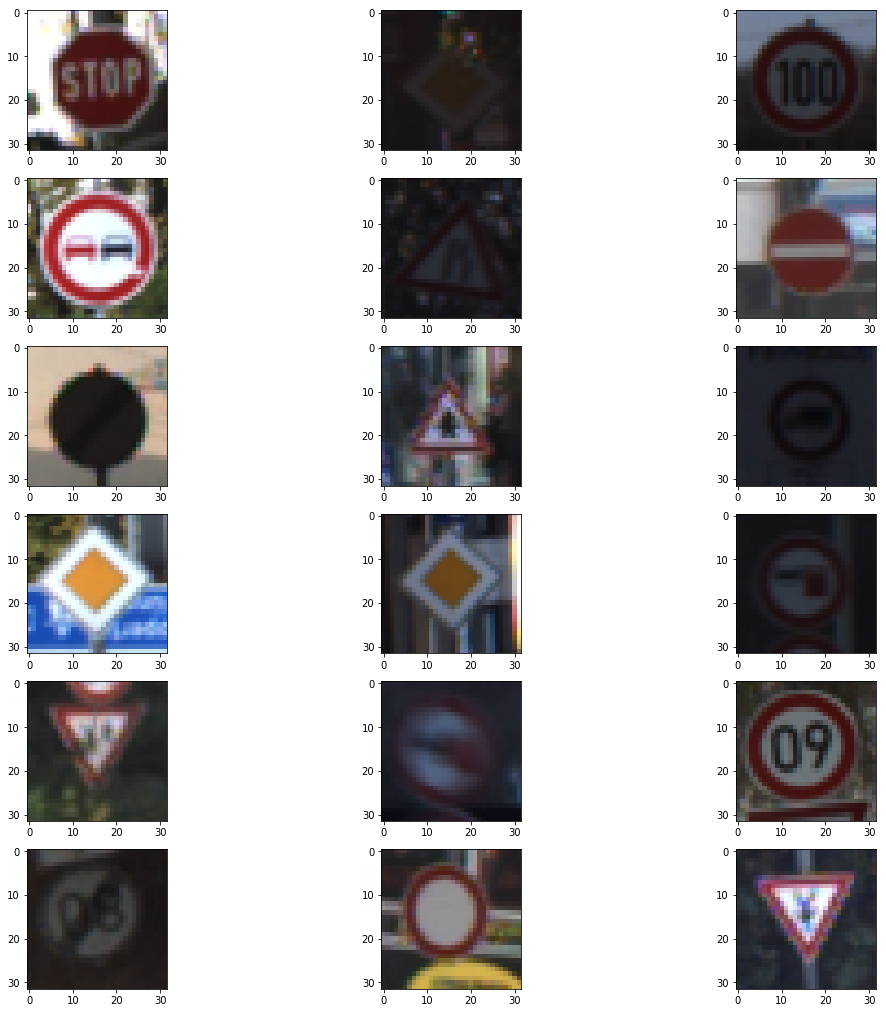

In [2]:
#============================================================================
# Data exploration, visualization, and prep

# select a few example images from a few classes from train\
def rand_subset(X_train, index = 9):
    #selected_classes = []
    #for i in range(0, 5):
        #selected_classes.append(randint(train["labels"].min(), train["labels"].max()))

    # grab a subset of classes
    #train_subset = {"features": train["features"] for label in selected_classes}

    # get a few random selections 
    selected_index = []
    for i in range(0, index):
        selected_index.append(randint(0, X_train.shape[0]))
    
    # final subset 
    train_subset = X_train[selected_index,:,:,:]
    
    return train_subset




#train_subset = rand_subset(X_train)

# preprocessing data 
# combine train and valid for joint processing
X_both = np.vstack([X_validation, X_train])

y_both = np.hstack([y_validation, y_train])

# define the rotation function. rotates to the left 90 degrees*times
def rotate(x, times = 0):
    for i in range(0, np.shape(x)[0]):
        x[i,:,:,0] = np.rot90(x[i,:,:,0], times)
        x[i,:,:,1] = np.rot90(x[i,:,:,1], times)
        x[i,:,:,2] = np.rot90(x[i,:,:,2], times)
    return x

# put the data prep steps in a function for easy repeat on test data
def data_prep(X, y):
    # get an upside down version 
    cpy = copy.deepcopy(X)
    X_c = rotate(cpy, 2)
    X_big = np.vstack([X_c, X])
    X_01 = X_big / 255
    
    # double up the labels and 
    y_01 = np.hstack([y, y])

    # shuyffle
    X_01, y_01 = shuffle(X_01, y_01)

    # the final has very small values, so wont look like anything look at the rotation
    x_sub = rand_subset(X_c)

    # the originals
    train_subset = rand_subset(X)
    
    tplot = []
    tplot = np.vstack([train_subset, x_sub])
    
    return X_01, y_01, tplot
    

# run prep function on training and validation combo data
X_01, y_01, tplot = data_prep(X_both, y_both)

# split into train and validation again 
X_train, X_validation, y_train, y_validation= train_test_split(X_01, y_01, test_size= 0.2)

# repeat prep on test data
X_test, y_test, plot_test = data_prep(X_test, y_test)

# plot seected examples from original and rotated sets
plt.figure(figsize=(18, 18))
for i, image in  enumerate(tplot):
    plt.subplot(6,3,1+i)
    plt.imshow(image)


## Model Archetecture
The model is a combination of the class lab on LeNet, my code, and inspiration from these sources:

source [1] https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf 


source [2] https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/

---

The archetecture is as follows: 

* Input   : 32x32x3


* Layer  1: 

    * 3x3x6 filter Convolution

    * 2x2x6 filter Max pool
    

* Layer  2: 5x5x12 filter Convolution


* Layer  3: Inception-like module concatonating:
    * 1x1x12 filter convolution
    
    * 1x1x12 filter convolution -> 5x5x12 filter convolution
    
    * 3x3x12 filter Max pool -> 1x1x12 filter convolution
    
    * 1x1x12 filter convlution -> 3x3x12 filter convolution
    
    
* Layer  4:
    * x7x60 filter convolution

    * x2x60 filter Max pool
     

* Layer  5: Fully connected with dropout 240x500

* Layer  6: Fully connected with dropout 500x250

* Layer  7: Fully connected with dropout 250x125

* Layer  8: Fully connected 125x43


* Output  : Softmax layer put in loss function

---

Loss function includes l2 regularization on all weights in fully connected layers.

In [10]:
#=============================================================================
# New net as described above. In addition to logits, returns the fully connected 
#  layer's weights for l2 penalty in loss function.  
def new_net(x):    
    #=============================================================================
    # hyper params
    mu = 0
    sigma = 0.1
    
    # added hyper parameter for dropout 
    keep_prob = 0.5
    #=============================================================================

    #=============================================================================
    # conv Layer 1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # pooling 1
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #=============================================================================

    #=============================================================================
    # conv Layer 2
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 12), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(12))
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    #=============================================================================
    
    #=============================================================================
    # layer 3: try inception-like layer 
    incept1_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept1_b = tf.Variable(tf.zeros(12))
    incept1   = tf.nn.conv2d(conv2, incept1_W, strides=[1, 1, 1, 1], padding='SAME') + incept1_b
    incept1 = tf.nn.relu(incept1)
    
    incept2_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept2_b = tf.Variable(tf.zeros(12))
    incept2   = tf.nn.conv2d(conv2, incept2_W, strides=[1, 1, 1, 1], padding='SAME') + incept2_b
    incept2 = tf.nn.relu(incept2)
    
    incept3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 12), mean = mu, stddev = sigma))
    incept3_b = tf.Variable(tf.zeros(12))
    incept3   = tf.nn.conv2d(incept2, incept3_W, strides=[1, 1, 1, 1], padding='SAME') + incept3_b
    incept3 = tf.nn.relu(incept3)
    
    incept4 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')

    incept5_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept5_b = tf.Variable(tf.zeros(12))
    incept5   = tf.nn.conv2d(incept4, incept5_W, strides=[1, 1, 1, 1], padding='SAME') + incept5_b
    incept5 = tf.nn.relu(incept5)
    
    incept6_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept6_b = tf.Variable(tf.zeros(12))
    incept6   = tf.nn.conv2d(conv2, incept6_W, strides=[1, 1, 1, 1], padding='SAME') + incept6_b
    incept6 = tf.nn.relu(incept6)
    
    incept7_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 12, 12), mean = mu, stddev = sigma))
    incept7_b = tf.Variable(tf.zeros(12))
    incept7   = tf.nn.conv2d(incept6, incept7_W, strides=[1, 1, 1, 1], padding='SAME') + incept7_b
    incept7 = tf.nn.relu(incept7)
    
    concat_layer = tf.concat(3,[incept1, incept3, incept5, incept7])
    concat_layer = tf.nn.relu(concat_layer)
    #=============================================================================
    
    #=============================================================================
    # layer 4: conv 2d
    conv3_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 48, 60), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(60))
    conv3   = tf.nn.conv2d(concat_layer, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    
    # pooling 2
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #=============================================================================
      
    #=============================================================================
    # flatten out for fc layer 
    fc0   = flatten(conv3_pool)
    #=============================================================================
    
    #=============================================================================
    # fully connected layers with dropout
    # layer 5: fully connected with dropout, relu
    fc1_W = tf.Variable(tf.truncated_normal(shape=(240, 500), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(500))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 6: Fully Connected with dropout, relu
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 250), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(250))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 7: Fully Connected with dropout, relu
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(250, 125), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(125))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    fc3    = tf.nn.relu(fc3)
    fc3    = tf.nn.dropout(fc3, keep_prob)

    # Layer 8: Fully Connected relu
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(125, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    #=============================================================================

    # return logits before softmax and fc weights
    return logits, fc1_W, fc2_W, fc3_W, fc4_W

## Define remainder of model and training gradient
* Define place holders
* Define learning rate input to Adam optimizer 
* Define l2 loss constant (ended up being 0.01, rather high in my oppinion
* Evaluation function, set to return accuracy, metric chosen from the lab material
* Set epochs
* Set batch size

I tried a few different batch sizes, including a large one, though the 128 seemed to be the fastest. Through manual hyper parameter tuning, I found about 40 epochs and a l2 loss constant of 0.01 to get a pretty good score. Additinoally, I tuned the keep_prob rate definined in the new_net function to 0.5 through trial and error. Additionally adadelta was used as an alternative optimization scheme, though adam proved to be better. 



In [12]:
#==========================================================================
# Define placeholders 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
#==========================================================================

#==========================================================================
# rate into Adam optimizer
rate = 0.001 
# hyper parameter: l2 loss constant, 1*10^-4 (my experience, kind of big.)
loss_const = 0.01 #0.0000411
#==========================================================================

#==========================================================================
# get outputs, calcualte loss and define training gradient
logits, fc1_W, fc2_W, fc3_W, fc4_W = new_net(x)
cross_entropy_l2 = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# calcualte the l2 loss penalty
loss_penalty = loss_const*tf.nn.l2_loss(fc1_W) + loss_const*tf.nn.l2_loss(fc2_W)\
+ loss_const*tf.nn.l2_loss(fc3_W) + loss_const*tf.nn.l2_loss(fc4_W)

# feed it into the mean 
loss_operation = tf.reduce_mean(cross_entropy_l2 + loss_penalty)

# keep adam as optimizer for now
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

# run minimize 
training_operation = optimizer.minimize(loss_operation)
#==========================================================================

## Model Evaluation
Evaluate the loss and accuracy of the trained model for a given dataset. The following code is from the class material. 

In [13]:
#============================================================================
# define the performance operations 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
#============================================================================

#============================================================================
# evaluate the model from the default session and input X and y. 
# use this equation for testing and on non-training data
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
#============================================================================

## Train the Model
Run the training data through the training pipeline to train the model. This function from the class material. 

Brief summary:

* Before each epoch, shuffles the training set.

* After each epoch, measures the loss and accuracy of the validation set.

* prints out training and validation metrics at each epoch

* Saves the model after training
___
The result, ~98% accuracy on train, ~97% accuracy on validation suggest that the model is not overfit, though, its worth exploring further.

In [16]:
#============================================================================
# Train the model on X_train and y_train from the data_prep function
EPOCHS = 35
# small batch size seems to run faster
BATCH_SIZE = 128
#============================================================================

#============================================================================
# Tensor flow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    print("epoch,train_acc,valid_acc")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
           
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        # edited for easy copy-paste to visualize training history 
        print("{}".format(i+1) + ",{:.3f}".format(training_accuracy) + ",{:.3f}".format(validation_accuracy)) 
    saver.save(sess, './nre_net')
    print()
    print("Model saved")
#============================================================================

Training...

epoch,train_acc,valid_acc
1,0.450,0.448
2,0.641,0.641
3,0.745,0.739
4,0.841,0.836
5,0.868,0.861
6,0.880,0.877
7,0.916,0.909
8,0.918,0.910
9,0.931,0.924
10,0.932,0.927
11,0.922,0.914
12,0.935,0.926
13,0.949,0.939
14,0.948,0.939
15,0.953,0.942
16,0.953,0.943
17,0.956,0.949
18,0.961,0.952
19,0.957,0.948
20,0.969,0.961
21,0.960,0.952
22,0.968,0.957
23,0.973,0.964
24,0.970,0.962
25,0.974,0.964
26,0.970,0.959
27,0.969,0.958
28,0.967,0.959
29,0.972,0.962
30,0.978,0.967
31,0.974,0.964
32,0.974,0.965
33,0.977,0.965
34,0.973,0.961
35,0.979,0.968

Model saved


## Just for fun
I ran a few "out-of-sample" picutres through the classifier just to see what it would predict. 







In [64]:
import matplotlib.image as mpimg
import os
#import Image

# file names of the exra pics
images = os.listdir("pics/small/")

# # read them in 
# extra_images = []
# for img in images:
#      read_in = (mpimg.imread("pics/small/" + img))
#      read_slice = read_in[:,:,0:3]
#      read_shape = np.ndarray(read_slice.astype("uint8"))
#      extra_images.append(read_slice)
# look = np.vstack(extra_images)
#x = np.adata =rray([np.ndarray(mpimg.imread("pics/small/" + img)) for img in images])
# np.shape(look)

images = os.listdir("pics/small/")
data = np.array([1, np.array([mpimg.imread("pics/small/" + images[i]) for i in range(images)])], dtype = np.float64) 


data = np.array([i*np.ones((5,5,3)) for i in range(10)], dtype = np.float64)


# convert to ndarray 
#see = np.asarray(extra_images)

#np.shape(see)
# see what the model says.. 



TypeError: 'list' object cannot be interpreted as an integer

## Evaluate the Model
Post-training an evalutation, I tested the model on a decent amount of hold-out data for a "one-and-done" number. 

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))